The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
%%capture

import sys
sys.path.append('..')
import mock_d2l_jax as d2l

# Linear Regression
:label:`sec_linear_regression`

*Regression* problems pop up whenever we want to predict a numerical value.
Common examples include predicting prices (of homes, stocks, etc.),
predicting the length of stay (for patients in the hospital),
forecasting demand (for retail sales), among countless others.
Not every prediction problem is a classic regression problem.
Later on, we will introduce classification problems,
where the goal is to predict membership among a set of categories.

As a running example, suppose that we wish
to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To develop a model for predicting house prices,
we need to get our hands on data consisting of sales,
including the sales price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (containing the data corresponding to one sale)
is called an *example* (or *data point*, *instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*).

## Basics

*Linear regression* may be both the simplest
and most popular among the standard tools
for tackling regression problems.
Dating back to the dawn of the 19th century :cite:`Legendre.1805,Gauss.1809`,
linear regression flows from a few simple assumptions.
First, we assume that the relationship
between features $\mathbf{x}$ and target $y$
is approximately linear,
i.e., that the conditional mean $E[Y|X=\mathbf{x}]$
can be expressed as a weighted sum
of the features $\mathbf{x}$.
This setup allows that the target value
may still deviate from its expected value
on account of observation noise.
Next, we can impose the assumption that any such noise
is well-behaved, following a Gaussian distribution.
Typically, we will use $n$ to denote
the number of examples in our dataset.
We use superscripts to enumerate samples and targets,
and subscripts to index coordinates.
More concretely,
$\mathbf{x}^{(i)}$ denotes the $i$-th sample
and $x_j^{(i)}$ denotes its $j$-th coordinate.

### Model
:label:`subsec_linear_model`

At the heart of every solution is a model
that describes how features can be transformed
into an estimate of the target.
The assumption of linearity means that
the expected value of the target (price) can be expressed
as a weighted sum of the features (area and age):

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$
:eqlabel:`eq_price-area`

Here $w_{\mathrm{area}}$ and $w_{\mathrm{age}}$
are called *weights*, and $b$ is called a *bias*
(or *offset* or *intercept*).
The weights determine the influence of each feature on our prediction.
The bias determines the value of the estimate when all features are zero.
Even though we will never see any newly-built homes with precisely zero area,
we still need the bias because it allows us
to express all linear functions of our features
(versus restricting us to lines that pass through the origin).
Strictly speaking, :eqref:`eq_price-area` is an *affine transformation* of input features, which is characterized by a *linear transformation* of features via weighted sum, combined with a *translation* via the added bias.
Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$
that, on average, make our model's predictions
fit the true prices observed in the data as closely as possible.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form,
as in :eqref:`eq_price-area`, is common.
In machine learning, we usually work
with high-dimensional datasets,
where it's more convenient to employ
compact linear algebra notation.
When our inputs consist of $d$ features,
we can assign each an index (between $1$ and $d$)
and express our prediction $\hat{y}$
(in general the "hat" symbol denotes an estimate) as

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly via the dot product
between $\mathbf{w}$ and $\mathbf{x}$:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

In :eqref:`eq_linreg-y`, the vector $\mathbf{x}$
corresponds to the features of a single example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.
For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$

where broadcasting (:numref:`subsec_broadcasting`) is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
that given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation)
be predicted with the lowest error.

Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$
might suffer small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters*
(or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a quality measure for some given model;
and (ii) a procedure for updating the model to improve its quality.

### Loss Function
:label:`subsec_linear-regression-loss-function`

Naturally, fitting our model to the data requires
that we agree on some measure of *fitness*
(or, equivalently, of *unfitness*).
*Loss functions* quantify the distance
between the *real* and *predicted* values of the target.
The loss will usually be a non-negative number
where smaller values are better
and perfect predictions incur a loss of 0.
For regression problems, the most common loss function is squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the *squared error* is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

The constant $\frac{1}{2}$ makes no real difference
but proves to be notationally convenient,
since it cancels out when we take the derivative of the loss.
Because the training dataset is given to us,
and thus out of our control,
the empirical error is only a function of the model parameters.
Below, we visualize the fit of a linear regression model
in a problem with one-dimensional inputs (:numref:`fig_fit_linreg`).

![Fitting a linear regression model to one-dimensional data.](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

Note that large differences between
estimates $\hat{y}^{(i)}$ and targets $y^{(i)}$
lead to even larger contributions to the loss,
due to the quadratic form of the loss
(this can be a double-edge sword.
While it encourages the model to avoid large errors
it can also lead to excessive sensitivity to anomalous data).
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### Analytic Solution

Unlike most of the models that we will cover,
linear regression presents us with
a surprisingly easy optimization problem.
In particular, we can find the optimal parameters
(as assessed on the training data)
analytically by applying a simple formula as follows.
First, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all ones.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
So long as the design matrix $\mathbf{X}$ has full rank
(no feature is linearly dependent on the others),
then there will be just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields:

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \text{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

Solving for $\mathbf{w}$ provides us with the optimal solution
for the optimization problem.
Note that this solution 

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

will only be unique
when the matrix $\mathbf X^\top \mathbf X$ is invertible,
i.e., when the columns of the design matrix
are linearly independent :cite:`Golub.Van-Loan.1996`.



While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude almost all exciting aspects of deep learning.

### Minibatch Stochastic Gradient Descent

Fortunately, even in cases where we cannot solve the models analytically,
we can still often train models effectively in practice.
Moreover, for many tasks, those difficult-to-optimize models
turn out to be so much better that figuring out how to train them
ends up being well worth the trouble.

The key technique for optimizing nearly any deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update,
even if the update steps might be very powerful :cite:`Liu.Nocedal.1989`.
Even worse, if there is a lot of redundancy in the training data,
the benefit of a full update is even lower.

The other extreme is to consider only a single example at a time and to take
update steps based on one observation at a time.
The resulting algorithm, *stochastic gradient descent* (SGD)
can be an effective strategy :cite:`Bottou.2010`, even for large datasets.
Unfortunately, SGD has drawbacks, both computational and statistical.
One problem arises from the fact that processors are a lot faster
multiplying and adding numbers than they are
at moving data from main memory to processor cache.
It is up to an order of magnitude more efficient to
perform a matrix-vector multiplication
than a corresponding number of vector-vector operations.
This means that it can take a lot longer to process
one sample at a time compared to a full batch.
A second problem is that some of the layers,
such as batch normalization (to be described in :numref:`sec_batch_norm`),
only work well when we have access
to more than one observation at a time.

The solution to both problems is to pick an intermediate strategy:
rather than taking a full batch or only a single sample at a time,
we take a *minibatch* of observations :cite:`Li.Zhang.Chen.ea.2014`.
The specific choice of the size of the said minibatch depends on many factors,
such as the amount of memory, the number of accelerators,
the choice of layers, and the total dataset size.
Despite all of that, a number between 32 and 256,
preferably a multiple of a large power of $2$, is a good start.
This leads us to *minibatch stochastic gradient descent*.

In its most basic form, in each iteration $t$,
we first randomly sample a minibatch $\mathcal{B}_t$
consisting of a fixed number $|\mathcal{B}|$ of training examples.
We then compute the derivative (gradient) of the average loss
on the minibatch with respect to the model parameters.
Finally, we multiply the gradient
by a predetermined small positive value $\eta$,
called the *learning rate*,
and subtract the resulting term from the current parameter values.
We can express the update as follows:

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

In summary, minibatch SGD proceeds as follows:
(i) initialize the values of the model parameters, typically at random;
(ii) iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
this has a closed-form expansion:

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

Since we pick a minibatch $\mathcal{B}$
we need to normalize by its size $|\mathcal{B}|$.
Frequently minibatch size and learning rate are user-defined.
Such tunable parameters that are not updated
in the training loop are called *hyperparameters*.
They can be tuned automatically by a number of techniques, such as Bayesian optimization
:cite:`Frazier.2018`. In the end, the quality of the solution is
typically assessed on a separate *validation dataset* (or *validation set*).

After training for some predetermined number of iterations
(or until some other stopping criterion is met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.
Note that even if our function is truly linear and noiseless,
these parameters will not be the exact minimizers of the loss, or even deterministic.
Although the algorithm converges slowly towards the minimizers
it typically cannot achieve it exactly in a finite number of steps.
Moreover, the minibatches $\mathcal{B}$
used to update the parameters are chosen at random.
This breaks determinism.

Linear regression happens to be a learning problem
with a global minimum
(whenever $\mathbf{X}$ is full rank, or equivalently,
whenever $\mathbf{X}^\top \mathbf{X}$ is invertible).
However, the lost surfaces for deep networks contain many saddle points and minima.
Fortunately, we typically don't care about finding
an exact set of parameters but merely any set of parameters
that leads to accurate predictions (and thus low loss).
In practice, deep learning practitioners
seldom struggle to find parameters
that minimize the loss *on training sets*
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`.
The more formidable task is to find parameters
that lead to accurate predictions on previously unseen data,
a challenge called *generalization*.
We return to these topics throughout the book.

### Predictions

Given the model $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$,
we can now make *predictions* for a new example,
e.g., to predict the sales price of a previously unseen house
given its area $x_1$ and age $x_2$.
Deep learning practitioners have taken to calling the prediction phase *inference*
but this is a bit of a misnomer---*inference* refers broadly
to any conclusion reached on the basis of evidence,
including both the values of the parameters
and the likely label for an unseen instance.
If anything, in the statistics literature
*inference* more often denotes parameter inference
and this overloading of terminology creates unnecessary confusion
when deep learning practitioners talk to statisticians.
In the following we will stick to *prediction* whenever possible.




## Vectorization for Speed

When training our models, we typically want to process
whole minibatches of examples simultaneously.
Doing this efficiently requires that (**we**) (~~should~~)
(**vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.**)


In [2]:
%matplotlib inline
import math
import time
import numpy as np
import jax.numpy as jnp
# from d2l import jax as d2l

To illustrate why this matters so much,
we can (**consider two methods for adding vectors.**)
To start, we instantiate two 10,000-dimensional vectors
containing all ones.
In one method, we loop over the vectors with a Python for-loop.
In the other method, we rely on a single call to `+`.


In [3]:
n = 10000
a = jnp.ones(n)
b = jnp.ones(n)

Now we can benchmark the workloads.
First, [**we add them, one coordinate at a time,
using a for-loop.**]


In [5]:
c = jnp.zeros(n)
t = time.time()
for i in range(n):
    c = c.at[i].set(a[i] + b[i])
f'{time.time() - t:.5f} sec'

'9.05404 sec'

(**Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum.**)


In [6]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00930 sec'

The second method is dramatically faster than the first.
Vectorizing code often yields order-of-magnitude speedups.
Moreover, we push more of the mathematics to the library
and need not write as many calculations ourselves,
reducing the potential for errors and increasing portability of the code.


## The Normal Distribution and Squared Loss
:label:`subsec_normal_distribution_and_squared_loss`

So far we've given a fairly functional motivation
of the squared loss objective:
the optimal parameters return the conditional expectation $E[Y|X]$
whenever the underlying pattern is truly linear,
and the loss assigns outsize penalties for outliers.
We can also provide a more formal motivation
for the squared loss objective
by making probabilistic assumptions
about the distribution of noise.

Linear regression was invented at the turn of the 19th century.
While it has long been debated whether Gauss or Legendre
first thought up the idea,
it was Gauss who also discovered the normal distribution
(also called the *Gaussian*).
It turns out that the normal distribution
and linear regression with squared loss
share a deeper connection than common parentage.

To begin, recall that a normal distribution
with mean $\mu$ and variance $\sigma^2$ (standard deviation $\sigma$)
is given as

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

Below [**we define a function to compute the normal distribution**].


In [7]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

We can now (**visualize the normal distributions**).


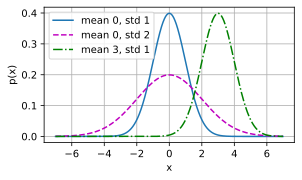

In [8]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Note that changing the mean corresponds
to a shift along the $x$-axis,
and increasing the variance
spreads the distribution out,
lowering its peak.

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise is normally distributed as follows:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y | \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y|\mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y | \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

If we assume that $\sigma$ is fixed,
we can ignore the first term,
because it does not depend on $\mathbf{w}$ or $b$.
The second term is identical
to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$ either.
It follows that minimizing the mean squared error
is equivalent to maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.


## Linear Regression as a Neural Network

While linear models are not sufficiently rich
to express the many complicated neural networks
that we will introduce in this book,
neural networks are rich enough
to subsume linear models as neural networks
in which every feature is represented by an input neuron,
all of which are connected directly to the output.

:numref:`fig_single_neuron` depicts
linear regression as a neural network.
The diagram highlights the connectivity pattern
such as how each input is connected to the output,
but not the specific values taken by the weights or biases.

![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

The inputs are $x_1, \ldots, x_d$.
We refer to $d$ as the *number of inputs*
or *feature dimensionality* in the input layer.
The output of the network is $o_1$.
Because we are just trying to predict
a single numerical value,
we have only one output neuron.
Note that the input values are all *given*.
There is just a single *computed* neuron.
In summary, we can think of linear regression
as a single-layer fully connected neural network.
We will encounter networks
with far more layers
in future chapters.

### Biology

Because linear regression predates computational neuroscience,
it might seem anachronistic to describe
linear regression in terms of neural networks.
Nonetheless, they were a natural place to start
when the cyberneticists and neurophysiologists
Warren McCulloch and Walter Pitts began to develop
models of artificial neurons.
Consider the cartoonish picture
of a biological neuron in :numref:`fig_Neuron`,
consisting of *dendrites* (input terminals),
the *nucleus* (CPU), the *axon* (output wire),
and the *axon terminals* (output terminals),
enabling connections to other neurons via *synapses*.

![The real neuron.](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

Information $x_i$ arriving from other neurons
(or environmental sensors) is received in the dendrites.
In particular, that information is weighted
by *synaptic weights* $w_i$,
determining the effect of the inputs,
e.g., activation or inhibition via the product $x_i w_i$.
The weighted inputs arriving from multiple sources
are aggregated in the nucleus
as a weighted sum $y = \sum_i x_i w_i + b$,
possibly subject to some nonlinear postprocessing via $\sigma(y)$.
This information is then sent via the axon to the axon terminals,
where it reaches its destination
(e.g., an actuator such as a muscle)
or it is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units
could be combined with the right connectivity
and right learning algorithm,
to produce far more interesting and complex behavior
than any one neuron alone could express
owes to our study of real biological neural systems.
At the same time, most research in deep learning today
draws inspiration from a much wider source.
We invoke Stuart Russell and Peter Norvig :cite:`Russell.Norvig.2016`
who pointed out that although airplanes might have been *inspired* by birds,
ornithology has not been the primary driver
of aeronautics innovation for some centuries.
Likewise, inspiration in deep learning these days
comes in equal or greater measure
from mathematics, linguistics, psychology,
statistics, computer science, and many other fields.

## Summary

In this section, we introduced
traditional linear regression,
where the parameters of a linear function
are chosen to minimize squared loss on the training set.
We also motivated this choice of objective
both via some practical considerations
and through an interpretation
of linear regression as maximimum likelihood estimation
under an assumption of linearity and Gaussian noise.
After discussing both computational considerations
and connections to statistics,
we showed how such linear models could be expressed
as simple neural networks where the inputs
are directly wired to the output(s).
While we will soon move past linear models altogether,
they are sufficient to introduce most of the components
that all of our models require:
parametric forms, differentiable objectives,
optimization via minibatch stochastic gradient descent,
and ultimately, evaluation on previously unseen data.



## Exercises

1. Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.
    1. Find an analytic solution for the optimal value of $b$.
    1. How does this problem and its solution relate to the normal distribution?
    1. What if we change the loss from $\sum_i (x_i - b)^2$ to $\sum_i |x_i-b|$? Can you find the optimal solution for $b$?
1. Prove that the affine functions that can be expressed by $\mathbf{x}^\top \mathbf{w} + b$ are equivalent to linear functions on $(\mathbf{x}, 1)$.
1. Assume that you want to find quadratic functions of $\mathbf{x}$, i.e., $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$. How would you formulate this in a deep network?
1. Recall that one of the conditions for the linear regression problem to be solvable was that the design matrix $\mathbf{X}^\top \mathbf{X}$ has full rank.
    1. What happens if this is not the case?
    1. How could you fix it? What happens if you add a small amount of coordinate-wise independent Gaussian noise to all entries of $\mathbf{X}$?
    1. What is the expected value of the design matrix $\mathbf{X}^\top \mathbf{X}$ in this case?
    1. What happens with stochastic gradient descent when $\mathbf{X}^\top \mathbf{X}$ doesn't have full rank?
1. Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
    1. Write out the negative log-likelihood of the data under the model $-\log P(\mathbf y \mid \mathbf X)$.
    1. Can you find a closed form solution?
    1. Suggest a minibatch stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?
1. Assume that we want to design a neural network with two layers by composing two linear layers. That is, the output of the first layer becomes the input of the second layer. Why would such a naive composition not work?
1. What happens if you want to use regression for realistic price estimation of houses or stock prices?
    1. Show that the additive Gaussian noise assumption is not appropriate. Hint: can we have negative prices? What about fluctuations?
    1. Why would regression to the logarithm of the price be much better, i.e., $y = \log \text{price}$?
    1. What do you need to worry about when dealing with pennystock, i.e., stock with very low prices? Hint: can you trade at all possible prices? Why is this a bigger problem for cheap stock?
    1. For more information review the celebrated Black-Scholes model for option pricing :cite:`Black.Scholes.1973`.
1. Suppose we want to use regression to estimate the *number* of apples sold in a grocery store.
    1. What are the problems with a Gaussian additive noise model? Hint: you are selling apples, not oil.
    1. The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) captures distributions over counts. It is given by $p(k|\lambda) = \lambda^k e^{-\lambda}/k!$. Here $\lambda$ is the rate function and $k$ is the number of events you see. Prove that $\lambda$ is the expected value of counts $k$.
    1. Design a loss function associated with the Poisson distribution.
    1. Design a loss function for estimating $\log \lambda$ instead.


[Discussions](https://discuss.d2l.ai/t/258)
